### HVE-WMP decomposition

### Decompose temperature into isopycnal heaving and WMP changes
Based on Bindoff and XY (YYYY), used in several papers by Dotto et al. 
Basic concept: Any change in temperature is due to displacement of isopycnals or due to changes along isopycnals. Quantifying these contributions can give insight into the respective forcing mechanisms. 
To disentangle the two we need to bin temperature into density space following the cosima recipe at: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Binning_transformation_from_depth_to_potential_density.ipynb 


In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import gsw
from xhistogram.xarray import histogram
import pygamma

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34029,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:39017,Total threads: 2
Dashboard: /proxy/43095/status,Memory: 15.75 GiB
Nanny: tcp://127.0.0.1:46863,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# This function does the rebinning into bins defined, weighted by defined weights. 
def weighted_rebin(data,rebin_info,bins,dim, weight,dimname):
    output = (histogram(rebin_info, 
                          bins = [bins], 
                          dim = [dim],
                          weights = data*weight)/histogram(rebin_info, 
                          bins = [bins], 
                          dim = [dim],
                          weights = weight)).rename({rebin_info.name + '_bin': dimname}) # rename vertical dimension
    return output

In [5]:
experiment = '01deg_jra55v140_iaf_cycle2'

lat_range = slice(-78, -72)
lon_range = slice(-125,-90)

In [6]:
# Calculate the terms on the large scale: Calculate annual
# We want to calculate HVE and WMP of temperature but using potential density referenced to 250dbar. Since this is not saved we need to calculate it manually. We need to load salinity for that , too. 
start_t = '2004-01-01 00:00:00' # start date, 
end_t = '2006-01-01 00:00:00' # end date
latrange = slice(-76,-70)
lonrange = slice(-111,-99)
strange = slice(0,1000)
t = cc.querying.getvar(experiment, 'temp', session, frequency = '1 monthly',
                       start_time=start_t, end_time=end_t).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).sel(st_ocean=strange).sel(time=slice(start_t,end_t))-273.15
area_t = cc.querying.getvar(experiment,'area_t',session, n=-1).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).fillna(1.0).astype(int) - 1
area_t = area_t.load()
ht = cc.querying.getvar(experiment,'ht',session, n=-1).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).load()
salt = cc.querying.getvar(experiment, 'salt', session,start_time=start_t, frequency = '1 monthly',
                            end_time=end_t).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).sel(st_ocean=strange).sel(time=slice(start_t,end_t))
sa = gsw.conversions.SA_from_SP(salt, salt.st_ocean, salt.xt_ocean, salt.yt_ocean)

rho250 = gsw.density.rho(sa, t, 250).rename('rho250') # Calculates potential density


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

In [7]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, start_time=start_t, end_time=start_t, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': t.yt_ocean, 'xt_ocean': t.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

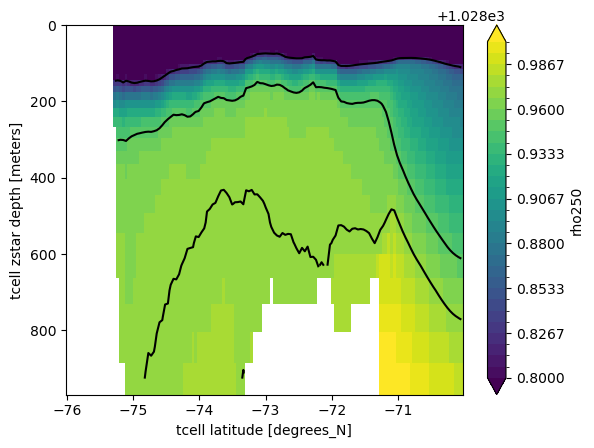

In [8]:
ax = plt.axes()
rho250.mean({'xt_ocean','time'}).plot(ax=ax,x='yt_ocean', levels=np.linspace(1028.8,1029,31))
rho250.mean({'xt_ocean','time'}).plot.contour(ax=ax,x='yt_ocean', levels=[1028.82,1028.95,1028.97], colors='k')
ax.invert_yaxis()

In [11]:
import pygamma
# Pygamma function gamma_n calculates neutral density based on 1997 Fortran code. 
# It needs practical salinity, potential temperature, pressure and lon-lat input. 
# We hence need to calculate pressure and potential temperature

pressure = gsw.p_from_z(-t.st_ocean,t.yt_ocean).expand_dims({'time':t.time,'xt_ocean':t.xt_ocean}).transpose('time','st_ocean','yt_ocean','xt_ocean')
SA = gsw.SA_from_SP(salt, pressure, salt.xt_ocean, salt.yt_ocean)
T = gsw.t_from_CT(SA, t, pressure)
PT = gsw.pt_from_CT(SA, t)


In [12]:
pygamma.gamma_n?

Signature: pygamma.gamma_n(s, t, p, lon, lat)
Docstring:
Arguments:
    salinity
    temperature
    pressure
    lon
    lat

s, t, p must be broadcastable against each other,
and 0-D, 1-D, or 2-D.  They may be masked, or nan
may be used for invalid values.
lon, lat must be at most 1-D, and not masked.

If lon and/or lat is 1-D, its length must match the *first*
dimension of s, t, p; in that case, if the latter are 2-D, their
*second* dimension must be the depth dimension.

Returns:
    gamma (generally a masked array or a scalar)
    dg_lo
    dg_hi
File:      ~/.local/lib/python3.10/site-packages/pygamma/__init__.py
Type:      function

In [13]:
# pygamma only works in 2D where the input variables are profiles at given lat, lon.
# We hence need to stack the variables together in horizontal space and time to get a 2D array for salinity, temperature and pressure (dimensions x depth) and 1D arrays for xt and yt (dimensions)
# This can take a while!
gamma, dg_lo, dg_hi = pygamma.gamma_n(salt.stack(z=("time", "yt_ocean","xt_ocean")).T, PT.stack(z=("time", "yt_ocean","xt_ocean")).T, pressure.stack(z=("time", "yt_ocean","xt_ocean")).T,(t.xt_ocean.expand_dims({'time':t.time,'yt_ocean':t.yt_ocean}).stack(z=("time", "yt_ocean","xt_ocean"))),t.yt_ocean.expand_dims({'time':t.time,'xt_ocean':t.xt_ocean}).stack(z=("time", "yt_ocean","xt_ocean")))

In [14]:
np.shape(gamma)

(408960, 46)

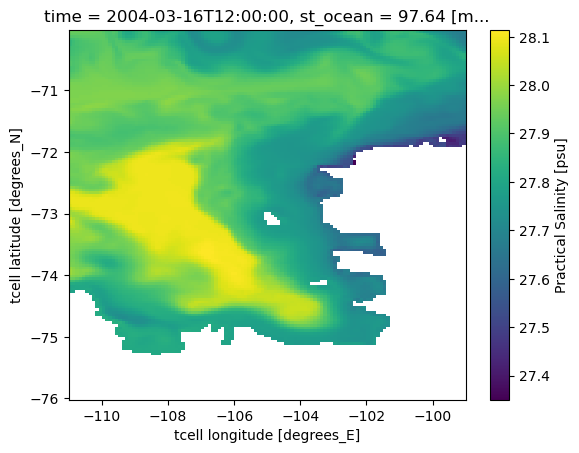

In [15]:
# gamma returns a numpy array. Make an xarray with the dimensions as above, fill the gamma data in and unstack to recover original dimensions
gamma_xr = SA.stack(z=("time", "yt_ocean","xt_ocean")).T.copy()
gamma_xr.values = gamma
gamma_xr = gamma_xr.unstack('z')

# Test plot
gamma_xr.sel(time='2004-03-15',method='nearest').sel(st_ocean = 100, method='nearest').plot()

In [51]:
# Save gamma_xr and reload: (if you want to save time with calculations)
f='/g/data/jk72/or6852/ensoant/gamma_xr_test.nc'
gamma_xr.to_dataset(name='gamma').to_netcdf(f) # save to file


In [52]:
f=xr.open_dataset('/g/data/jk72/or6852/ensoant/gamma_xr_test.nc',engine='netcdf4')#.isel(time=slice(myr,61))
gamma_xr = f.gamma


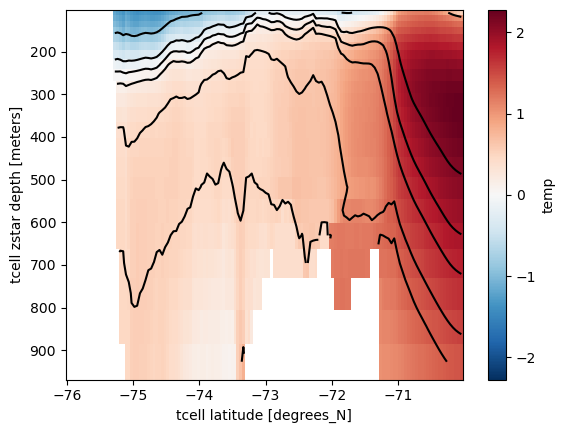

In [16]:
# Gamma section test plot
ax = plt.axes()
t.mean({'time','xt_ocean'}).sel(st_ocean = slice(100,1000)).plot(x='yt_ocean',ax=ax)
gamma_xr.mean({'time','xt_ocean'}).sel(st_ocean = slice(100,1000)).plot.contour(x='yt_ocean',levels=[27.9,28,28.03,28.05,28.08,28.1],colors='k',ax=ax)
ax.invert_yaxis()

In [26]:
# Define bins for rebinning! Make sure bins cover the entire density range and have sufficient resolution. In the Amundsen Sea it's mostly between 1028.8 and 1029 kg/m3, so this seems to be a good definition for bins but I have not done much sensitivity testing. 

targetbins250 = np.concatenate((np.arange(1026.5,1028,.02),np.arange(1028,1028.8,.01),np.arange(1028.8,1029.1,.002)),axis=0) # define targetbins as np-array
targetbins250 = xr.DataArray(data = targetbins250, dims='rho',coords=dict(targetbins250=(['rho'], targetbins250))) # transform to xarray, necessary for xhistogram
targetbins250 = targetbins250.rename('targetbins250')

# Define targetbins for neutral density: Based on paper by Dotto et al., 2019, with small adaptations. Can check the histogram below to check if it covers the range of densities okay
neut_bin = np.concatenate((np.arange(26.5,26.99,0.01),np.arange(27,27.799,0.002),np.arange(27.8,28.1499,0.001), np.arange(28.15,28.28,0.01)),axis=0)
neut_bin = xr.DataArray(data = neut_bin, dims='rho',coords=dict(neut_bin=(['rho'], neut_bin))) # transform to xarray, necessary for xhistogram
neut_bin = neut_bin.rename('neut_bin')


# Define bins in depth space for rebinning. I define it by the means between two depth levels. 

st_ocean_bins = np.concatenate(([0],(t.st_ocean.values[1:]+t.st_ocean.values[:-1])/2,[6000]),axis=0)

(array([7.6260e+03, 7.8460e+03, 8.3070e+03, 8.1020e+03, 8.1000e+03,
        8.2280e+03, 8.5900e+03, 8.4320e+03, 8.9230e+03, 8.9990e+03,
        9.0140e+03, 8.9500e+03, 9.2010e+03, 8.6880e+03, 8.9270e+03,
        9.3230e+03, 9.0360e+03, 9.1920e+03, 9.3460e+03, 9.5910e+03,
        9.2090e+03, 9.1850e+03, 9.3990e+03, 8.9880e+03, 9.2660e+03,
        9.5770e+03, 9.4220e+03, 9.9480e+03, 9.9590e+03, 1.0499e+04,
        1.0676e+04, 1.0720e+04, 1.0945e+04, 1.0603e+04, 1.0846e+04,
        1.1024e+04, 1.0979e+04, 1.1375e+04, 1.1475e+04, 1.1445e+04,
        1.1207e+04, 1.1076e+04, 1.1449e+04, 1.1377e+04, 1.1667e+04,
        1.1683e+04, 1.1827e+04, 1.2553e+04, 2.5756e+04, 2.6410e+03,
        2.7150e+03, 2.6410e+03, 2.8150e+03, 2.7270e+03, 2.7130e+03,
        2.7560e+03, 2.6870e+03, 2.7270e+03, 2.6430e+03, 2.8080e+03,
        2.8510e+03, 2.9670e+03, 2.8690e+03, 2.8570e+03, 2.9380e+03,
        3.0490e+03, 3.0470e+03, 2.9390e+03, 3.1190e+03, 3.0440e+03,
        3.0810e+03, 3.1080e+03, 2.9970e+03, 3.08

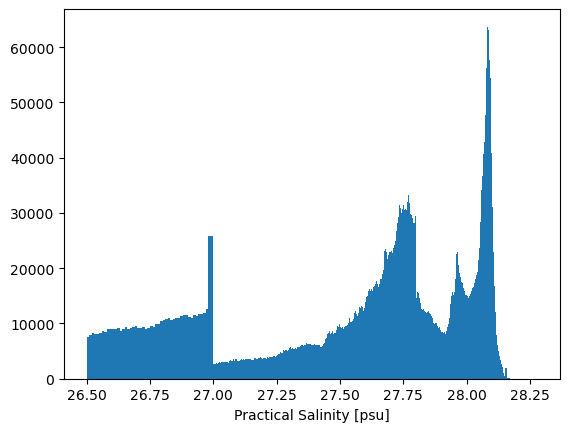

In [27]:
gamma_xr.plot(bins=neut_bin)

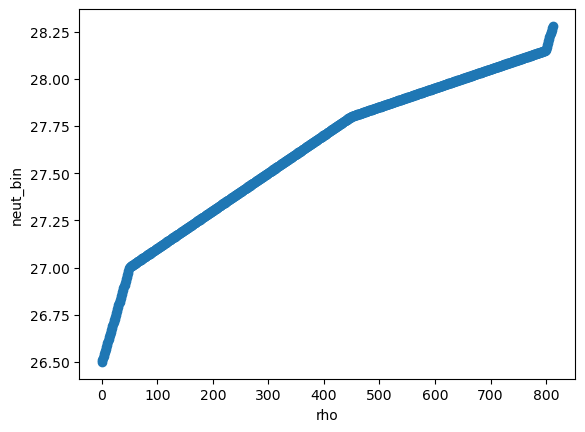

In [28]:
neut_bin.plot(marker='o')

Calculation: First using potentital density referenced to 250dbar

dTheta/dt (depth space) = dTheta/dt (density space) - dz/dt (density space) * dTheta/dz (density space, time mean)

In [29]:
# Calculations: 
dtdz = t.mean('time').differentiate('st_ocean') # average temperature gradient

# rebin to density space:
# rename variables (the histogram function wants the same names)
t = t.rename('t')
dtdz = dtdz.rename('dtdz')
pot_rho = rho250.rename('pot_rho')

# Rebin, rename again, and interpolate gaps
dtdz_on_rho = weighted_rebin(dtdz,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho')
dtdz_on_rho = dtdz_on_rho.rename('dtdz_on_rho')
dtdz_on_rho = dtdz_on_rho.where(np.isfinite(dtdz_on_rho)).interpolate_na(dim="rho") # empty density classes are filled by linear interpolation

# Temperature 
t_on_rho = weighted_rebin(t,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho')
t_on_rho = t_on_rho.rename('t_on_rho')
t_on_rho = t_on_rho.where(np.isfinite(t_on_rho)).interpolate_na(dim="rho")

# st ocean
st_on_rho = weighted_rebin(t.st_ocean,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho')
st_on_rho = st_on_rho.rename('st_on_rho')
st_on_rho = st_on_rho.where(np.isfinite(st_on_rho)).interpolate_na(dim="rho")

# Calculate terms and rename
HVE_on_rho = (st_on_rho - st_on_rho.mean('time'))*dtdz_on_rho # HVE on density space defined as vertical displacement of isopycnals * background T gradient
HVE_on_rho = HVE_on_rho.rename('HVE_on_rho')

WMP_on_rho = t_on_rho - t_on_rho.mean('time') # WMP: Simply temperature anomalies on isopycnals
WMP_on_rho = WMP_on_rho.rename('WMP_on_rho')

# Rebin to depth space
HVE = weighted_rebin(HVE_on_rho,rebin_info = st_on_rho,bins=st_edges_ocean[:47].values,dim='rho', weight=targetbins250.diff('rho'),dimname='st_ocean')
HVE = HVE.rename('HVE')
HVE = HVE.where(np.isfinite(HVE)).interpolate_na(dim="st_ocean")
HVE = HVE.assign_coords(st_ocean=t.st_ocean) # Make sure vertical coordinates are the same as before transformation into density space

WMP = weighted_rebin(WMP_on_rho,rebin_info = st_on_rho,bins=st_edges_ocean[:47].values,dim='rho', weight=targetbins250.diff('rho'),dimname='st_ocean')
WMP = WMP.rename('WMP')
WMP = WMP.where(np.isfinite(WMP)).interpolate_na(dim="st_ocean")
WMP = WMP.assign_coords(st_ocean=t.st_ocean)

In [30]:
# Calculate a test decomposition for PIG box: HVE+WMP should be equal to original temperature (small errors introduced by rebinning, interpolation and using background temperature gradient, errors assumed to grow away from reference density)
hve_pig = HVE.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(thickness.fillna(0)*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})
wmp_pig = WMP.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(thickness.fillna(0)*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})
ts_pig = t.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(thickness.fillna(0)*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

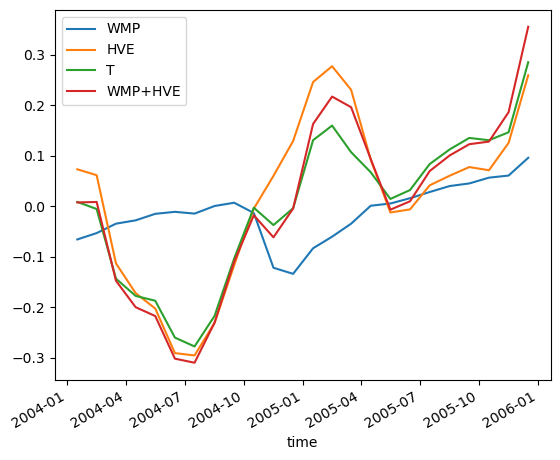

In [31]:
ax = plt.axes()
wmp_pig.plot(ax=ax, label='WMP')
(-hve_pig).plot(ax=ax, label='HVE') # Note minus as I have defined HVE as positive before (can change that in calculations)
(ts_pig-ts_pig.mean('time')).plot(ax=ax, label='T')
(wmp_pig-hve_pig).plot(ax=ax, label='WMP+HVE')
ax.legend()

Redo the calculations using neutral density: Need to split this up in two parts and let the calculations done underway as it could not handle the full calculation at once at the end...

In [57]:
# Calculations: 
# This is a fairly big calculation, and dask has issues to handle it without loading the data, so we need to generate all the data first (using load)
dtdz = t.mean('time').differentiate('st_ocean').load() # average temperature gradient

# rebin to density space:
# rename variables (the histogram function wants the same names)
t = t.rename('t').load()
dtdz = dtdz.rename('dtdz').load()
gamma_xr = gamma_xr.rename('gamma_xr').load()

# Rebin, rename again, and interpolate gaps
dtdz_on_g = weighted_rebin(dtdz,rebin_info = gamma_xr,bins=neut_bin.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho').compute()
dtdz_on_g = dtdz_on_g.rename('dtdz_on_g')
dtdz_on_g = dtdz_on_g.where(np.isfinite(dtdz_on_g)).interpolate_na(dim="rho") # empty density classes are filled by linear interpolation

# Temperature 
t_on_g = weighted_rebin(t,rebin_info = gamma_xr,bins=neut_bin.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho').compute()
t_on_g = t_on_g.rename('t_on_g')
t_on_g = t_on_g.where(np.isfinite(t_on_g)).interpolate_na(dim="rho")#.load()

# st ocean
st_on_g = weighted_rebin(t.st_ocean,rebin_info = gamma_xr,bins=neut_bin.values,dim='st_ocean', weight=thickness.sel(st_ocean = slice(0,1000)),dimname='rho').compute()
st_on_g = st_on_g.rename('st_on_g')
st_on_g = st_on_g.where(np.isfinite(st_on_g)).interpolate_na(dim="rho")#.load()

In [58]:
# Calculate terms and rename
HVE_on_g = (st_on_g - st_on_g.mean('time'))*dtdz_on_g # HVE on density space defined as vertical displacement of isopycnals * background T gradient
HVE_on_g = HVE_on_g.rename('HVE_on_g').compute()

WMP_on_g = t_on_g - t_on_g.mean('time') # WMP: Simply temperature anomalies on isopycnals
WMP_on_g = WMP_on_g.rename('WMP_on_g').compute()

# Rebin to depth space
HVEg = weighted_rebin(HVE_on_g,rebin_info = st_on_g,bins=st_edges_ocean[:47].values,dim='rho', weight=neut_bin.diff('rho'),dimname='st_ocean')
HVEg = HVEg.rename('HVE')
HVEg = HVEg.where(np.isfinite(HVEg)).interpolate_na(dim="st_ocean")
HVEg = HVEg.assign_coords(st_ocean=t.st_ocean).compute() # Make sure vertical coordinates are the same as before transformation into density space

WMPg = weighted_rebin(WMP_on_g,rebin_info = st_on_g,bins=st_edges_ocean[:47].values,dim='rho', weight=neut_bin.diff('rho'),dimname='st_ocean')
WMPg = WMPg.rename('WMP')
WMPg = WMPg.where(np.isfinite(WMPg)).interpolate_na(dim="st_ocean")
WMPg = WMPg.assign_coords(st_ocean=t.st_ocean).compute()

In [59]:
# Calculate a test decomposition for PIG box: HVE+WMP should be equal to original temperature (small errors introduced by rebinning, interpolation and using background temperature gradient, errors assumed to grow away from reference density)
hveg_pig = HVEg.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(thickness*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})
wmpg_pig = WMPg.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(thickness*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})


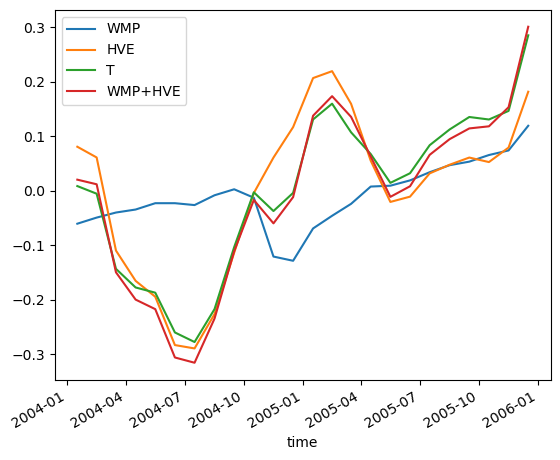

In [60]:
ax = plt.axes()
wmpg_pig.plot(ax=ax, label='WMP')
(-hveg_pig).plot(ax=ax, label='HVE') # Note minus as I have defined HVE as positive before (can change that in calculations)
(ts_pig-ts_pig.mean('time')).plot(ax=ax, label='T')
(wmpg_pig-hveg_pig).plot(ax=ax, label='WMP+HVE')
ax.legend()